# Survival analysis

Ver [notebook de ejemplo de la libreria](https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/00-introduction.ipynb)

Primero cargo los labels y los features.

In [1]:
import pandas as pd

In [2]:
dtype = {
    'device_id': 'int64',
    'auctionsCount': 'float64',
    'auctionsMostFreqDay': 'float64',
    'auctionsMeanInterval': 'float64',
    'auctionsStdDevInterval': 'float64',
    'auctionsAproxFreq': 'float64',
    'auctionsLast': 'float64'
}

In [3]:
featuresAuctions = pd.read_csv('data/auctionsFeaturesFirstThreeDays.csv', usecols=dtype.keys(), dtype=dtype)

In [4]:
dtype = {
    'device_id': 'int64',
    'eventsCount': 'float64',
    'eventsMostFreqDay': 'float64',
    'eventsMeanInterval': 'float64',
    'eventsStdDevInterval': 'float64',
    'eventsAproxFreq': 'float64',
    'eventsLast': 'float64'
}

In [5]:
featuresEvents = pd.read_csv('data/eventsFeaturesFirstThreeDays.csv', usecols=dtype.keys(), dtype=dtype)

In [6]:
features = pd.merge(featuresAuctions, featuresEvents, how='outer')

In [7]:
dtype = {
    'device_id': 'int64',
    'st': 'float64'
}

In [8]:
labels = pd.read_csv('data/labelsFirstThreeDays.csv', usecols=dtype.keys(), dtype=dtype)

In [9]:
labels = labels.merge(features[['device_id']])

El id del device no me interesa, pero las filas labels y features deben coincidir para un dispositivo. Por eso ordeno por dispositivo y luego tiro los id.

In [10]:
labels = labels.sort_values(by='device_id').reset_index(drop=True)

In [11]:
features = features.sort_values(by='device_id').reset_index(drop=True)

In [12]:
labels = labels.drop('device_id', axis=1)

In [13]:
features = features.drop('device_id', axis=1)

En analisis de supervivencia, si no se llegama a registrar un evento (porque esta fuera de la ventana de 3 dias) se dice que esta censurado. Para cualquier analisis que se quiera hacer, se necesita saber cual evento se registro (uncensored == `True`) y cual no (uncensored == `False`).

In [14]:
labels['uncensored'] = labels['st'].notnull()

Para los eventos censurados, el valor que importa es la ultima vez que se supo de ese dispositivo. En este caso, se sabe que hasta la ultima hora del tercer dia el evento (auction) no se produjo. Por los tanto, $y$ tiene ese valor.

In [15]:
secondsInThreeDays = 3 * 24 * 60 * 60
labels['st'] = labels['st'].fillna(secondsInThreeDays)

El modelo que vamos a entrenar no hacepta nulos

In [16]:
features = features.fillna(0)

In [17]:
labels.head()

,st,uncensored
0,259200.000000,False
1,259200.000000,False
2,259200.000000,False
3,259200.000000,False
4,88.851558,True


Vemos la cantidad de eventos registrados, y censurados.

In [18]:
labels['uncensored'].value_counts()

True     247656
False    159413
Name: uncensored, dtype: int64

In [19]:
features.head()

,auctionsCount,auctionsMostFreqDay,auctionsMeanInterval,auctionsAproxFreq,auctionsStdDevInterval,auctionsLast,eventsCount,eventsMostFreqDay,eventsMeanInterval,eventsAproxFreq,eventsStdDevInterval,eventsLast
0,35.0,3.0,5400.569164,0.000185,26777.818183,189019.920750,88.0,3.0,2190.301273,0.000457,12501.025059,192746.512
1,8.0,3.0,23581.596135,0.000042,66376.255608,188652.769083,0.0,0.0,0.000000,0.000000,0.000000,0.000
2,6.0,1.0,1748.256831,0.000572,4222.014848,10489.540987,8.0,2.0,18506.979875,0.000054,52213.999252,148055.839
3,1.0,3.0,256765.420614,0.000004,0.000000,256765.420614,0.0,0.0,0.000000,0.000000,0.000000,0.000
4,7.0,3.0,36811.037843,0.000027,46058.714104,257677.264901,13.0,1.0,4642.311923,0.000215,16645.826680,60350.055


Ahora que ya tengo los datos cargados y en orden, se puede pasar al modelo

## Entrenamiento del modelo y analisis

Defino la cantidad de datos que se van a usar para entrenar el modelo, y cuantos se van a usar para validar.

In [20]:
n1 = 300000
n2 = 10000

In [21]:
labelsTrain = labels.iloc[:n1]

In [22]:
featuresTrain = features.iloc[:n1]

In [23]:
labelsTest = labels.iloc[n1:n1+n2]

In [24]:
featuresTest = features.iloc[n1:n1+n2]

El modelo que se eligio es Cox proportional hazard's model (el mas simple). Hay algunos mas, habria que probarlos y analisar si producen mejores resultados.

In [25]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
estimator = CoxPHSurvivalAnalysis(verbose=True)

El modelo pide que los labels sean un 'structured array' de python. Por suerte, la libreria provee funciones para obtener estos a partir de un DataFrame de Pandas

In [26]:
from sksurv.util import Surv
util = Surv()
saLabelsTrain = util.from_dataframe('uncensored', 'st', labelsTrain)
saLabelsTest = util.from_dataframe('uncensored', 'st', labelsTest)

Entrenamos el modelo. Da un par de errores, creo que es porque en features hay una columna que es inversa de otra.

In [27]:
estimator.fit(featuresTrain, saLabelsTrain)

C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-conditioned matrix (rcond=1.55016e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-conditioned matrix (rcond=6.69074e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-conditioned matrix (rcond=2.67451e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-conditioned matrix (rcond=2.04868e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-con

iter      8: optimization converged


CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=True)

El modelo devuelve un ceoficiente para cada feature llamado [Log Hazard Ratio](https://en.wikipedia.org/wiki/Hazard_ratio).

In [28]:
pd.Series(estimator.coef_, index=featuresTrain.columns)

auctionsCount             4.478998e-04
auctionsMostFreqDay       2.168486e-02
auctionsMeanInterval     -5.334017e-06
auctionsAproxFreq         7.421467e+00
auctionsStdDevInterval   -6.648840e-06
auctionsLast              9.541905e-06
eventsCount              -5.288387e-04
eventsMostFreqDay        -8.508809e-02
eventsMeanInterval        1.245618e-08
eventsAproxFreq          -1.302542e+01
eventsStdDevInterval      1.395028e-08
eventsLast                2.135336e-07
dtype: float64

Ahora quiero ver que tan bien predice el modelo. Hago dos predicciones, una para una parte de los datos con los que se entreno el modelo, y otra para datos nuevos.

Es importante aclarar que el modelo no predice el valor $S_t$ que queremos, sino un valor de 'riesgo' del dispositivo. Es decir, para cada instante $t$, cual es el riego de que suceda el evento

In [32]:
predictionTrain = estimator.predict(featuresTrain.iloc[:n2])
predictionTest = estimator.predict(featuresTest)

La performance se mide con un indice que se fija que el orden corresponda con los labels. Es decir, que si $a$ tiene mayor riesgo que $b$, entonces $a$ debe haber sucedido primero.

In [33]:
from sksurv.metrics import concordance_index_censored
resultTrain = concordance_index_censored(saLabelsTrain[:n2]['uncensored'], saLabelsTrain[:n2]["st"], predictionTrain)
resultTest = concordance_index_censored(saLabelsTest['uncensored'], saLabelsTest["st"], predictionTest)

El valor que nos interesa aca es el primero. 0 indica un modelo totalmente contrario a la realidad, 0,5 un modelo aleatorio y 1 un modelo perfecto. El segundo valor es la cantidad de pares que concordaban, y el tercero es la cantidad de pares que no concordaban.

In [34]:
resultTrain

(0.7510813979188226, 31784021, 10533657, 1, 0)

In [35]:
resultTest

(0.7420289463072816, 31631179, 10996779, 1, 0)

El modelo tambien puede predecir las funciones de supervivencia: $H(t) = P(T > t)$. Es decir, para cada instante $t$, la probabilidad de que el evento ocurra luego de $t$.

Aca muestro las funciones de 5 muestras.

In [36]:
pred_surv = estimator.predict_survival_function(featuresTest.head(5))

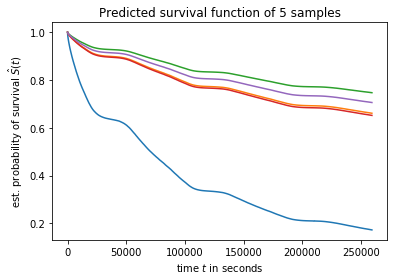

In [38]:
import matplotlib.pyplot as plt
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post")
plt.title('Predicted survival function of 5 samples')
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ in seconds")
plt.show()

Por ultimo, puedo entrenar el modelo para cada feature, usando solo esa feature y evaluar el resultado para cada una de ellas. De esta manera puede ver cual es la feature que mejor predice.

score hace los mismo que hice antes, predice un resultado y luego obtiene su concordance index

In [39]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(featuresTest.values, saLabelsTest)
pd.Series(scores, index=featuresTest.columns).sort_values(ascending=False)

auctionsLast              0.725827
auctionsCount             0.717803
auctionsAproxFreq         0.684577
auctionsMostFreqDay       0.641353
auctionsStdDevInterval    0.600921
eventsAproxFreq           0.591417
eventsCount               0.589641
eventsMostFreqDay         0.586034
eventsLast                0.585911
eventsMeanInterval        0.584684
eventsStdDevInterval      0.568352
auctionsMeanInterval      0.451897
dtype: float64

La pregunta obvia es: Como mierda obtengo los valores de $S_t(d)$ a partir de esto? Las opciones que se me ocurren son:

    1. La Esperanza de la funcion de supervicencia,
    2. algun cuantil fijo de la funcion de supervicencia, o
    3. con un algoritmo de machine learning de regresion, predecir el cuantil para cada dispositivo.

Y por que no se puede usar un modelo de regresion directamente para predecir el valor de $S_t(d)$?

    Se puede, pero como gran parte de los datos estan censurados, el modelo va a tratar de predecir casi siempre el tiempo maximo, y asi pegarle con exactitud a un monton de datos. Estos algoritmos de survival analisis estan pensados especialmente para atacar esta tipo de problemas.
    De todas maneras, siempre se puede probar y ver que funciona mejor.